In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np
import inla


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


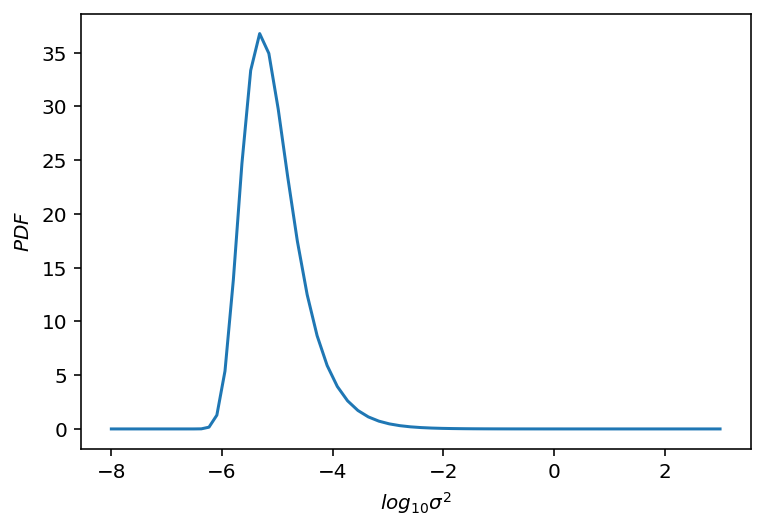

exact CDF:  0.00922569143991095
numerical integration CDF:  0.009225691439910979
error:  2.7755575615628914e-17


In [31]:

def log_gauss_rule(N, a, b):
    A = np.log(a)
    B = np.log(b)
    p, w = inla.gauss_rule(N, a=A, b=B)
    pexp = np.exp(p)
    wexp = np.exp(p) * w
    return (pexp, wexp)

a = 1e-8
b = 1e3
pexp, wexp = log_gauss_rule(90, a, b)
alpha = 0.0005
beta = 0.000005
f = scipy.stats.invgamma.pdf(pexp, alpha, scale=beta)
exact = scipy.stats.invgamma.cdf(b, alpha, scale=beta) - scipy.stats.invgamma.cdf(a, alpha, scale=beta)
est = np.sum(f * wexp)
plt.plot(np.log(pexp) / np.log(10), f)
plt.xlabel('$log_{10}\sigma^2$')
plt.ylabel('$PDF$')
plt.show()
print('exact CDF: ', exact),
print('numerical integration CDF: ', est)
print('error: ', est - exact)
sigma2_rule = (pexp, wexp)

# The model and simulations.

To match with the INLA notation, the $\theta$ parameter for Berry et al 2013 is called $x$ here. Also, Berry uses:
\begin{equation}
\tilde{x} = logit(p) - logit(p_1)
\end{equation}
whereas we use:
\begin{equation}
x = logit(p) = \tilde{x} + logit(p_1)
\end{equation}

In [32]:
p0 = np.full(4, 0.1) # rate of response below this is the null hypothesis
p1 = np.full(4, 0.3) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_x = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_x = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.full(4, 0.85)

# early stopping criterion
pmid_accept = 0.9
pmid_fail = 0.05

null_x_berry = np.log(p0 / (1 - p0)) - np.log(p1 / (1 - p1))
null_x = np.log(p0 / (1 - p0))
prior_mu_mean = null_x[0]

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior

In [33]:
# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10,15,20,25,30,35]])
y_i = np.array([[1, 6, 3, 3], [3, 8, 5, 4], [6,9,7,5], [7,10,8,7], [8,10,9,8], [11, 11, 10, 9]])
data = np.stack((y_i, n_i), axis=2)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

mu_rule = inla.gauss_rule(201, -5, 3)

In [34]:
y_i / n_i

array([[0.1       , 0.6       , 0.3       , 0.3       ],
       [0.2       , 0.53333333, 0.33333333, 0.26666667],
       [0.3       , 0.45      , 0.35      , 0.25      ],
       [0.28      , 0.4       , 0.32      , 0.28      ],
       [0.26666667, 0.33333333, 0.3       , 0.26666667],
       [0.31428571, 0.31428571, 0.28571429, 0.25714286]])

In [35]:
import dirty_bayes

In [36]:
quad_rules = [mu_rule, sigma2_rule]
theta_grid = np.stack(
    np.meshgrid(*[q[0] for q in quad_rules], indexing="ij"), axis=-1
)
prior_logdensity = berry_prior(theta_grid)
prior_logdensity

array([[-492.47537385, -483.08714887, -466.6537687 , ...,  -19.98454622,
         -20.01886526,  -20.0379546 ],
       [-492.47537351, -483.08714853, -466.65376836, ...,  -19.98454588,
         -20.01886492,  -20.03795426],
       [-492.47537289, -483.08714792, -466.65376774, ...,  -19.98454526,
         -20.01886431,  -20.03795365],
       ...,
       [-492.47632979, -483.08810481, -466.65472464, ...,  -19.98550216,
         -20.01982121,  -20.03891055],
       [-492.47633093, -483.08810595, -466.65472578, ...,  -19.9855033 ,
         -20.01982234,  -20.03891168],
       [-492.47633156, -483.08810658, -466.65472641, ...,  -19.98550393,
         -20.01982297,  -20.03891232]])

In [124]:
N = 6
d = 4
phat = y_i[:, :] / n_i[:, :]
thetahat = scipy.special.logit(phat)
sample_I = n_i[:, :] * phat * (1 - phat)  # diag(n*phat*(1-phat))
mu_0 = np.full_like(phat, -1.34)

In [127]:
mu_sig_sq = mu_rule[0][:, None] * sigma2_rule[0][None, :]
sigma_sq = np.tile(sigma2_rule[0][None, :], (mu_sig_sq.shape[0], 1))
mu_posterior = np.empty((N, *sigma_sq.shape, d))
sigma_posterior = np.empty((N, *sigma_sq.shape, d))
density_sigma_given_y = np.empty((N, *sigma_sq.shape, d))
for k in range(N):
    for i in range(mu_rule[0].shape[0]):
        for j in range(sigma2_rule[0].shape[0]):
            mu = mu_rule[0][i]
            sig2 = sigma2_rule[0][j]
            (
                mu_posterior[k, i, j],
                sigma_posterior[k, i, j],
            ) = dirty_bayes.calc_posterior_x(
                np.array([sig2]),
                np.array([mu * sig2]),
                sample_I[k],
                thetahat[k],
                mu_0[k],
                d,
            )
            density_sigma_given_y[k, i, j] = scipy.stats.multivariate_normal.pdf(
                thetahat[k],
                mu_0[k],
                (
                    np.diag(sample_I[k] ** -1)
                    + np.diag(np.repeat(sigma_sq[i, j], d))
                    + mu_sig_sq[i, j],
                ),
            )


In [ ]:
def calc_sigma2_given_y(sigma_sq, mu_sig_sq, sample_I, thetahat, mu_0, d):
    # for pt in np.exp(pts):
    # print(np.diag(sample_I**-1) + np.diag(np.repeat(pt, d)) + mu_sig_sq)
    density_sigma_given_y = np.array(density_sigma_given_y)
    print(density_sigma_given_y / density_sigma_given_y.sum())
    final_weights = wts * prior * density_sigma_given_y
    final_weights /= np.sum(final_weights)


In [ ]:
weights(np.array([sig2]), np.array([mu * sig2]))

In [117]:
# mu_posterior, sigma_posterior = dirty_bayes.calc_posterior_x2(
#     sigma_sq, 
#     mu_sig_sq,
#     sample_I,
#     thetahat,
#     mu_0,
#     d 
# )

In [122]:
sigma_sq.shape

(201, 90)

In [ ]:
density_sigma_given_y = [
    scipy.stats.multivariate_normal.pdf(
        thetahat,
        np.repeat(mu_0, d),
        np.diag(sample_I**-1) + np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq,
    )
    for sigma_sq in sigma2_rule[0]
]

In [31]:
density_logspace = scipy.stats.invgamma.pdf(
    sigma2_rule[0], a=0.0005, scale=0.000005
)
density_sigma_given_y = [
    scipy.stats.multivariate_normal.pdf(
        thetahat,
        np.repeat(mu_0, d),
        np.diag(sample_I**-1) + np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq,
    )
    for sigma_sq in sigma2_rule[0]
]
# for pt in np.exp(pts):
# print(np.diag(sample_I**-1) + np.diag(np.repeat(pt, d)) + mu_sig_sq)
density_sigma_given_y = np.array(density_sigma_given_y)
print(density_sigma_given_y / density_sigma_given_y.sum())
final_weights = sigma2_rule[1] * density_logspace * density_sigma_given_y
final_weights /= np.sum(final_weights)

[1.67017635e-02 1.67017635e-02 1.67017635e-02 1.67017635e-02
 1.67017635e-02 1.67017636e-02 1.67017636e-02 1.67017637e-02
 1.67017637e-02 1.67017638e-02 1.67017639e-02 1.67017640e-02
 1.67017642e-02 1.67017644e-02 1.67017647e-02 1.67017651e-02
 1.67017656e-02 1.67017663e-02 1.67017672e-02 1.67017685e-02
 1.67017702e-02 1.67017726e-02 1.67017760e-02 1.67017808e-02
 1.67017877e-02 1.67017976e-02 1.67018118e-02 1.67018327e-02
 1.67018633e-02 1.67019087e-02 1.67019762e-02 1.67020774e-02
 1.67022299e-02 1.67024608e-02 1.67028121e-02 1.67033489e-02
 1.67041720e-02 1.67054384e-02 1.67073918e-02 1.67104108e-02
 1.67150827e-02 1.67223156e-02 1.67335061e-02 1.67507862e-02
 1.67773684e-02 1.68180010e-02 1.68794848e-02 1.69710589e-02
 1.71041128e-02 1.72899591e-02 1.75331618e-02 1.78164884e-02
 1.80741133e-02 1.81581524e-02 1.78267361e-02 1.68067216e-02
 1.49532148e-02 1.24058581e-02 9.56979508e-03 6.90524175e-03
 4.71631648e-03 3.09186129e-03 1.97137231e-03 1.23617471e-03
 7.69006081e-04 4.776763

In [ ]:
thetahat

array([-2.19722458,  0.40546511, -0.84729786, -0.84729786])

In [32]:
model.log_prior()

<function __main__.berry_prior(theta)>

In [91]:

post_theta, report = inla.calc_posterior_theta(model, data, (mu_rule, sigma2_rule))

In [7]:

def plot_field(logpost_theta_data, field, levels=None, label=None):
    MM = logpost_theta_data["theta_grid"][:,:,0]
    SS = logpost_theta_data["theta_grid"][:,:,1]
    log_sigma_grid = np.log10(SS)
    cntf = plt.contourf(
        MM, log_sigma_grid, field, levels=levels, extend="both"
    )
    plt.contour(
        MM,
        log_sigma_grid,
        field,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    cbar = plt.colorbar(cntf)
    if label is not None:
        cbar.set_label(None)
    plt.xlabel("$\mu$")
    plt.ylabel("$\log_{10} (\sigma^2)$")

$$1.0 = \sum_i f(x_i) w_i$$

"CDF" is:
* $f(x_i)$

"cumulative prob" is:
* $f(x_i) * w_i$

the cdf would be... 
$$ F(x_j) = \sum_{i < j} f(x_i) w_i$$ 

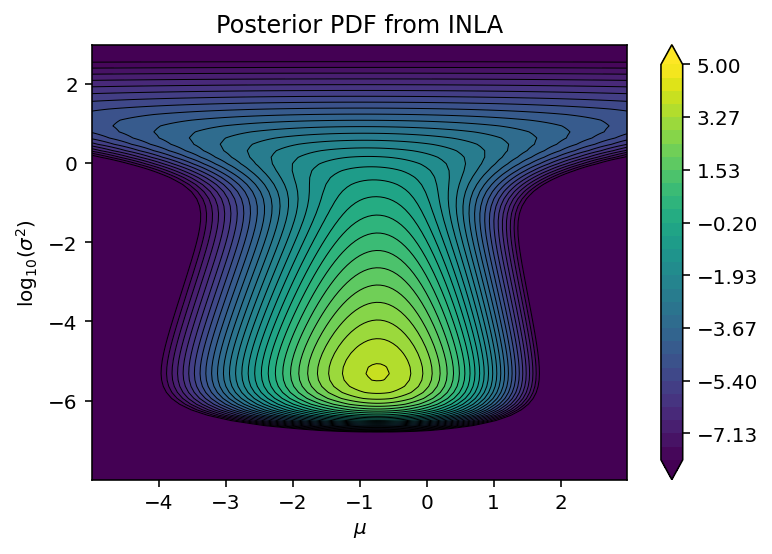

In [8]:
levels = np.linspace(-8, 5, 31)
field = np.log10(post_theta[0]).reshape(report['theta_grid'].shape[:2])
field[np.isnan(field) | np.isinf(field)] = -20
plt.title(f"Posterior PDF from INLA")
plot_field(report, field, levels=levels, label="$\log_{10}$ (density)")

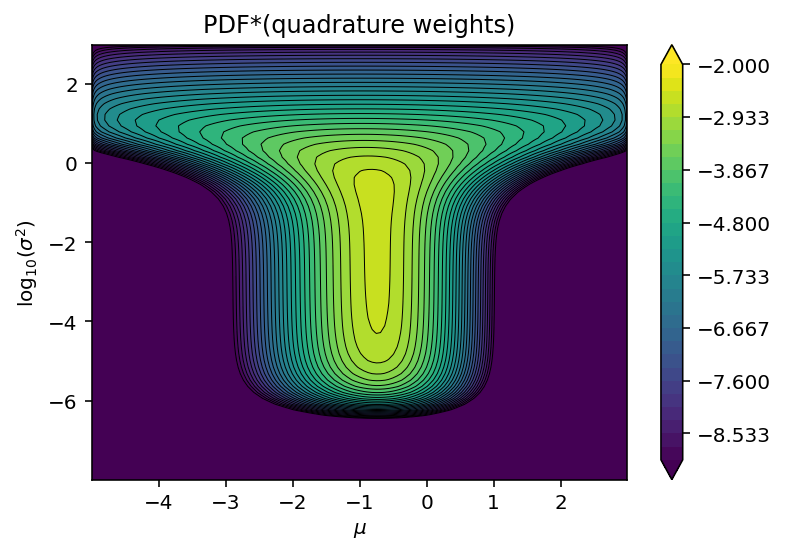

In [9]:
cell_volume = mu_rule[1][:, None] * sigma2_rule[1][None, :]
cell_volume = scipy.ndimage.gaussian_filter(cell_volume, 1.0)
levels = np.linspace(-9, -2, 31)

field = np.log10(post_theta[0] * cell_volume).reshape(report['theta_grid'].shape[:2])
field[np.isnan(field) | np.isinf(field)] = -20
plt.title(f"PDF*(quadrature weights)")
plot_field(report, field, levels=levels, label="$\log_{10}$ (density)")
plt.show()

In [10]:
def figure1_plot(data, post_theta, report):
    mu_post, sigma_post = inla.calc_posterior_x(post_theta, report)

    # expit(mu_post) is the posterior estimate of the mean probability.
    p_post = scipy.special.expit(mu_post)

    # two sigma confidence intervals transformed from logit to probability space.
    cilow = scipy.special.expit(mu_post - 2 * sigma_post)
    cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

    y = data[:, :, 0]
    n = data[:, :, 1]

    # The simple ratio of success to samples. Binomial "p".
    raw_ratio = y / n
    p_success = np.empty_like(mu_post)

    # early stopping criterion
    p_success[:5] = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post[:5], sigma_post[:5])
    # final success criterion
    p_success[5] = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post[5], sigma_post[5])


    fig = plt.figure(figsize=(15, 10))
    outergs = fig.add_gridspec(2, 3, hspace=0.3)
    for i in range(data.shape[0]):

        innergs = outergs[i].subgridspec(
            2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
        )

        plt.subplot(innergs[0])
        plt.plot(np.arange(4), raw_ratio[i], "kx")
        plt.plot(np.arange(4), p_post[i], "ko", mfc="none")
        plt.plot(np.arange(4), p_success[i], "k ", marker=(8, 2, 0))

        plt.vlines(np.arange(4), cilow[i], cihigh[i], color="k", linewidth=1.0)

        if i < 5:
            plt.title(f"Interim Analysis {i+1}")
            plt.hlines([pmid_fail, pmid_accept], -1, 4, colors=["k"], linestyles=["--"])
            plt.text(-0.1, 0.91, "Early Success", fontsize=7)
            plt.text(2.4, 0.06, "Early Futility", fontsize=7)
        else:
            plt.title("Final Analysis")
            plt.hlines([pfinal_thresh[0]], -1, 4, colors=["k"], linestyles=["--"])
            plt.text(-0.1, 0.86, "Final Success", fontsize=7)

        plt.xlim([-0.3, 3.3])
        plt.ylim([0.0, 1.05])
        plt.yticks(np.linspace(0.0, 1.0, 6))
        plt.xlabel("Group")
        plt.ylabel("Probability")

        plt.subplot(innergs[1])
        plt.bar(
            [0, 1, 2, 3],
            n[i],
            tick_label=[str(i) for i in range(4)],
            color=(0.6, 0.6, 0.6, 1.0),
            edgecolor="k",
            zorder=0,
        )
        plt.bar(
            [0, 1, 2, 3],
            y[i],
            color=(0.6, 0.6, 0.6, 1.0),
            hatch="////",
            edgecolor="w",
            lw=1.0,
            zorder=1,
        )
        #         # draw hatch
        # ax1.bar(range(1, 5), range(1, 5), color='none', edgecolor='red', hatch="/", lw=1., zorder = 0)
        # # draw edge
        plt.bar([0, 1, 2, 3], y[i], color="none", edgecolor="k", zorder=2)
        ticks = np.arange(0, 36, 5)
        plt.yticks(ticks, [str(i) if i % 10 == 0 else "" for i in ticks])
        plt.xticks(np.arange(4), ['1', '2', '3', '4'])
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        plt.xlabel("Group")
        plt.ylabel("N")

    plt.show()


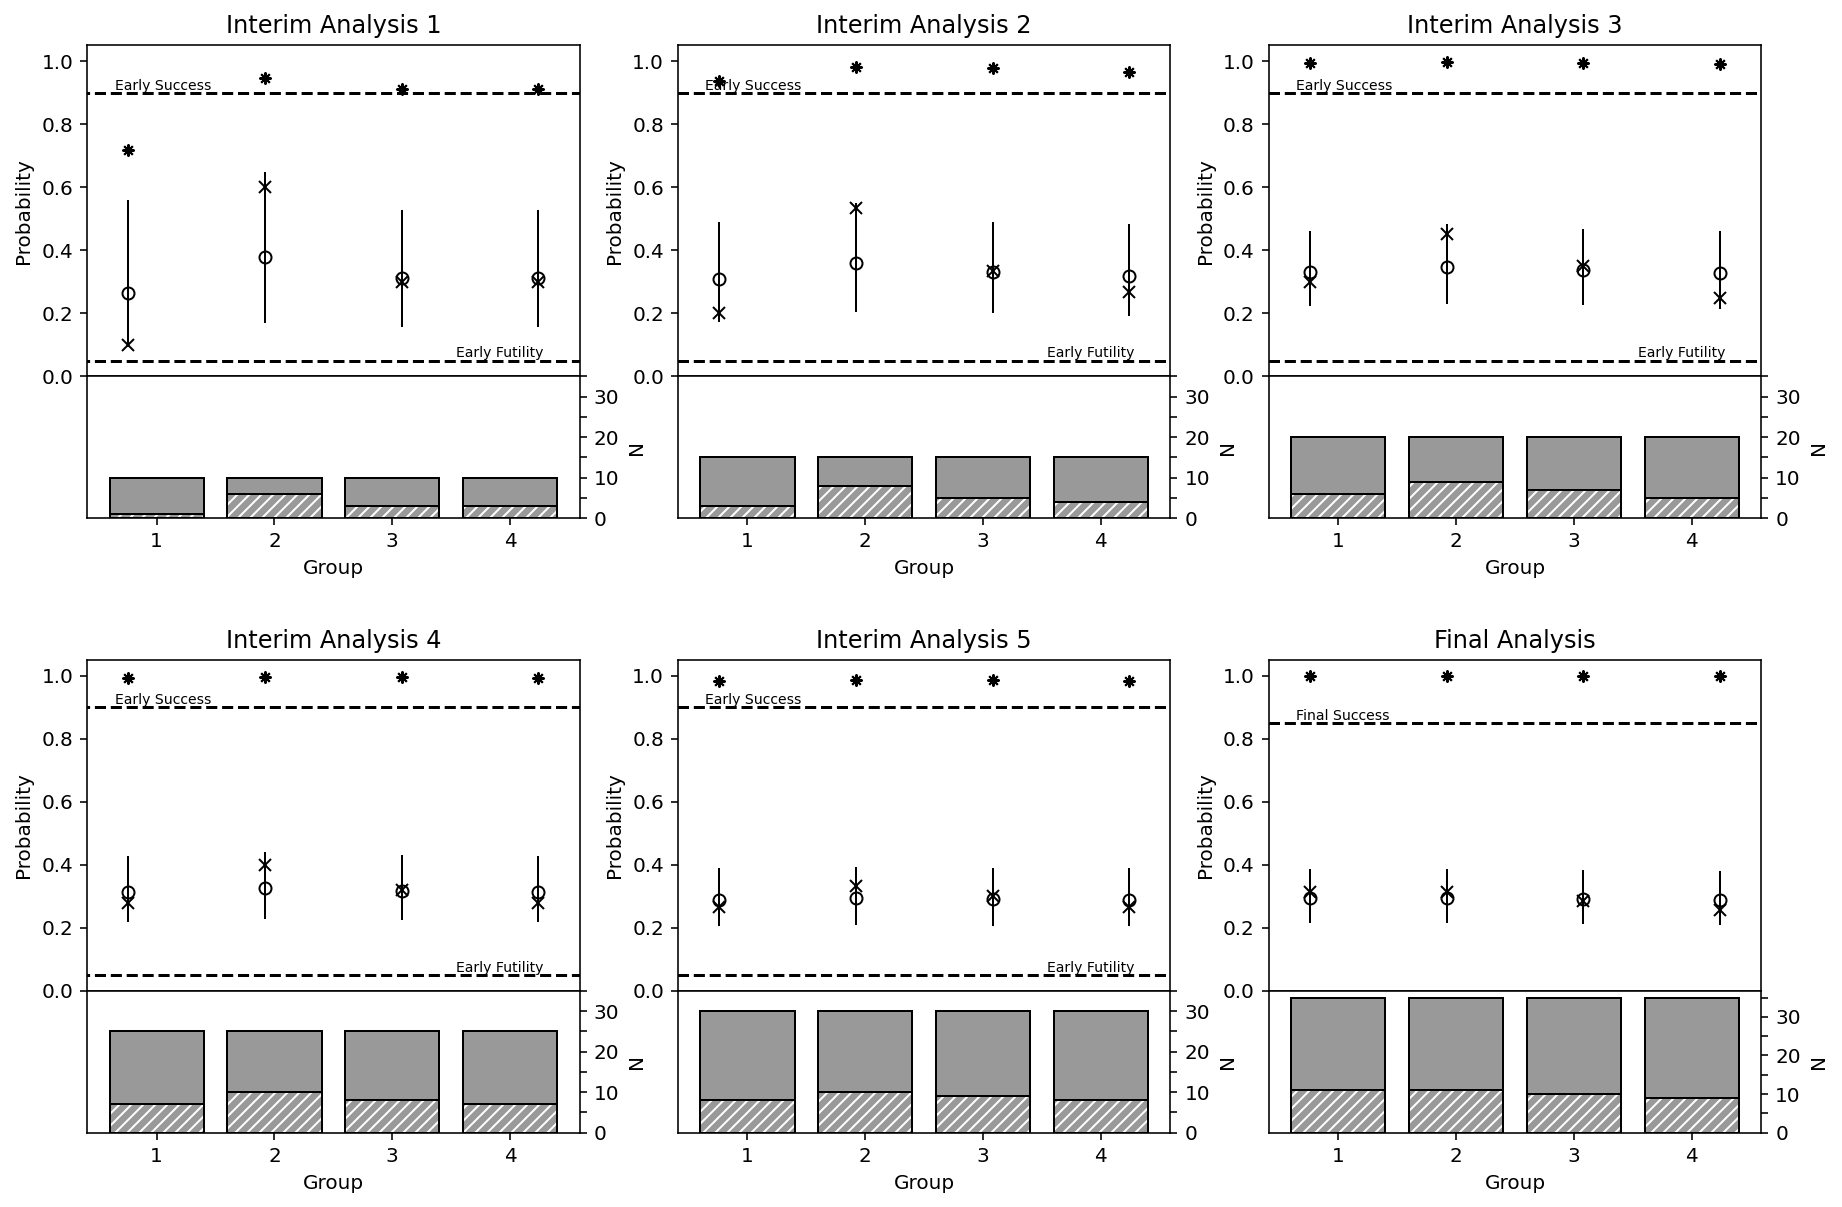

In [11]:
figure1_plot(data, post_theta, report)

# Figure 2

In [12]:

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i2 = np.array([[10, 10, 10, 10], [15, 15, 15, 15], [20, 20, 20, 20], [20, 20, 25, 25], [20, 20, 30, 30], [20, 20, 35, 35]])
y_i2 = np.array([[0, 1, 3, 3], [0, 1, 4, 5], [0, 1, 6, 6], [0, 1, 6, 7], [0, 1, 7, 8], [0, 1, 9, 10]], dtype=np.float64)
data2 = np.stack((y_i2, n_i2), axis=2)
mu_rule = inla.gauss_rule(201, -7, 1.5)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior
post_theta2, report2 = inla.calc_posterior_theta(model, data2, (mu_rule, sigma2_rule))

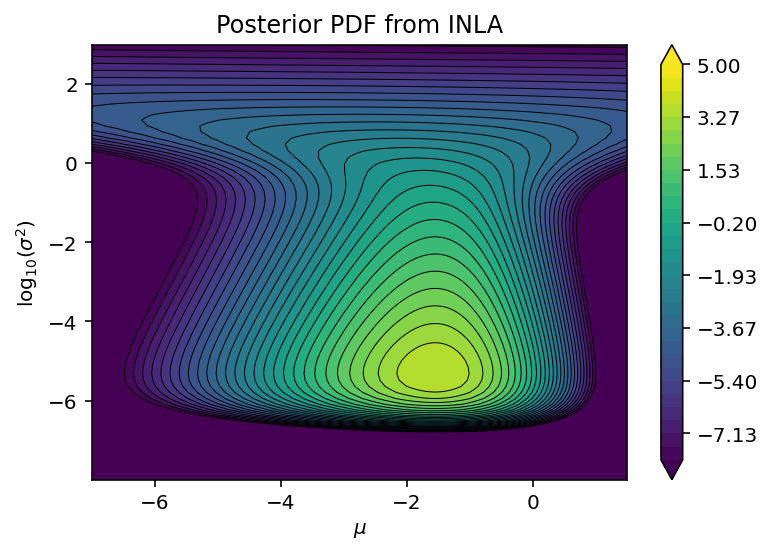

In [13]:
levels = np.linspace(-8, 5, 31)

field = np.log10(post_theta2[0]).reshape(report2['theta_grid'].shape[:2])
field[np.isnan(field) | np.isinf(field)] = -20
plt.title(f"Posterior PDF from INLA")
plot_field(report2, field, levels=levels, label="$\log_{10}$ (density)")

In [14]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta2, report2)

# expit(mu_post) is the posterior estimate of the mean probability.
p_post = scipy.special.expit(mu_post)

# two sigma confidence intervals transformed from logit to probability space.
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

y = data2[:, :, 0]
n = data2[:, :, 1]

# The simple ratio of success to samples. Binomial "p".
raw_ratio = y / n
p_success = np.empty_like(mu_post)

# early stopping criterion
p_success[:5] = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post[:5], sigma_post[:5])
# final success criterion
p_success[5] = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post[5], sigma_post[5])

In [15]:
mu_post[:,0]

array([-2.05072398, -2.77557402, -3.60049067, -3.33540292, -3.280594  ,
       -3.52457562])

In [16]:
sigma_post[:,0]

array([1.21548735, 1.78693051, 2.12068751, 1.97567123, 1.95126363,
       2.07985438])

In [17]:
n_sims = post_theta2.shape[0]
n_sigma2 = post_theta2.shape[1]
n_mu = post_theta2.shape[2]
n_arms = report2["x0"].shape[-1]
x_mu = report2["x0"].reshape((n_sims, n_sigma2, n_mu, n_arms))
theta_grid = report2['theta_grid']
H = report2["H"]
x_sigma2 = -(1.0 / H).reshape((n_sims, n_sigma2, n_mu, n_arms))
T = (x_mu - mu_post[:, None, None, :]) ** 2 + x_sigma2

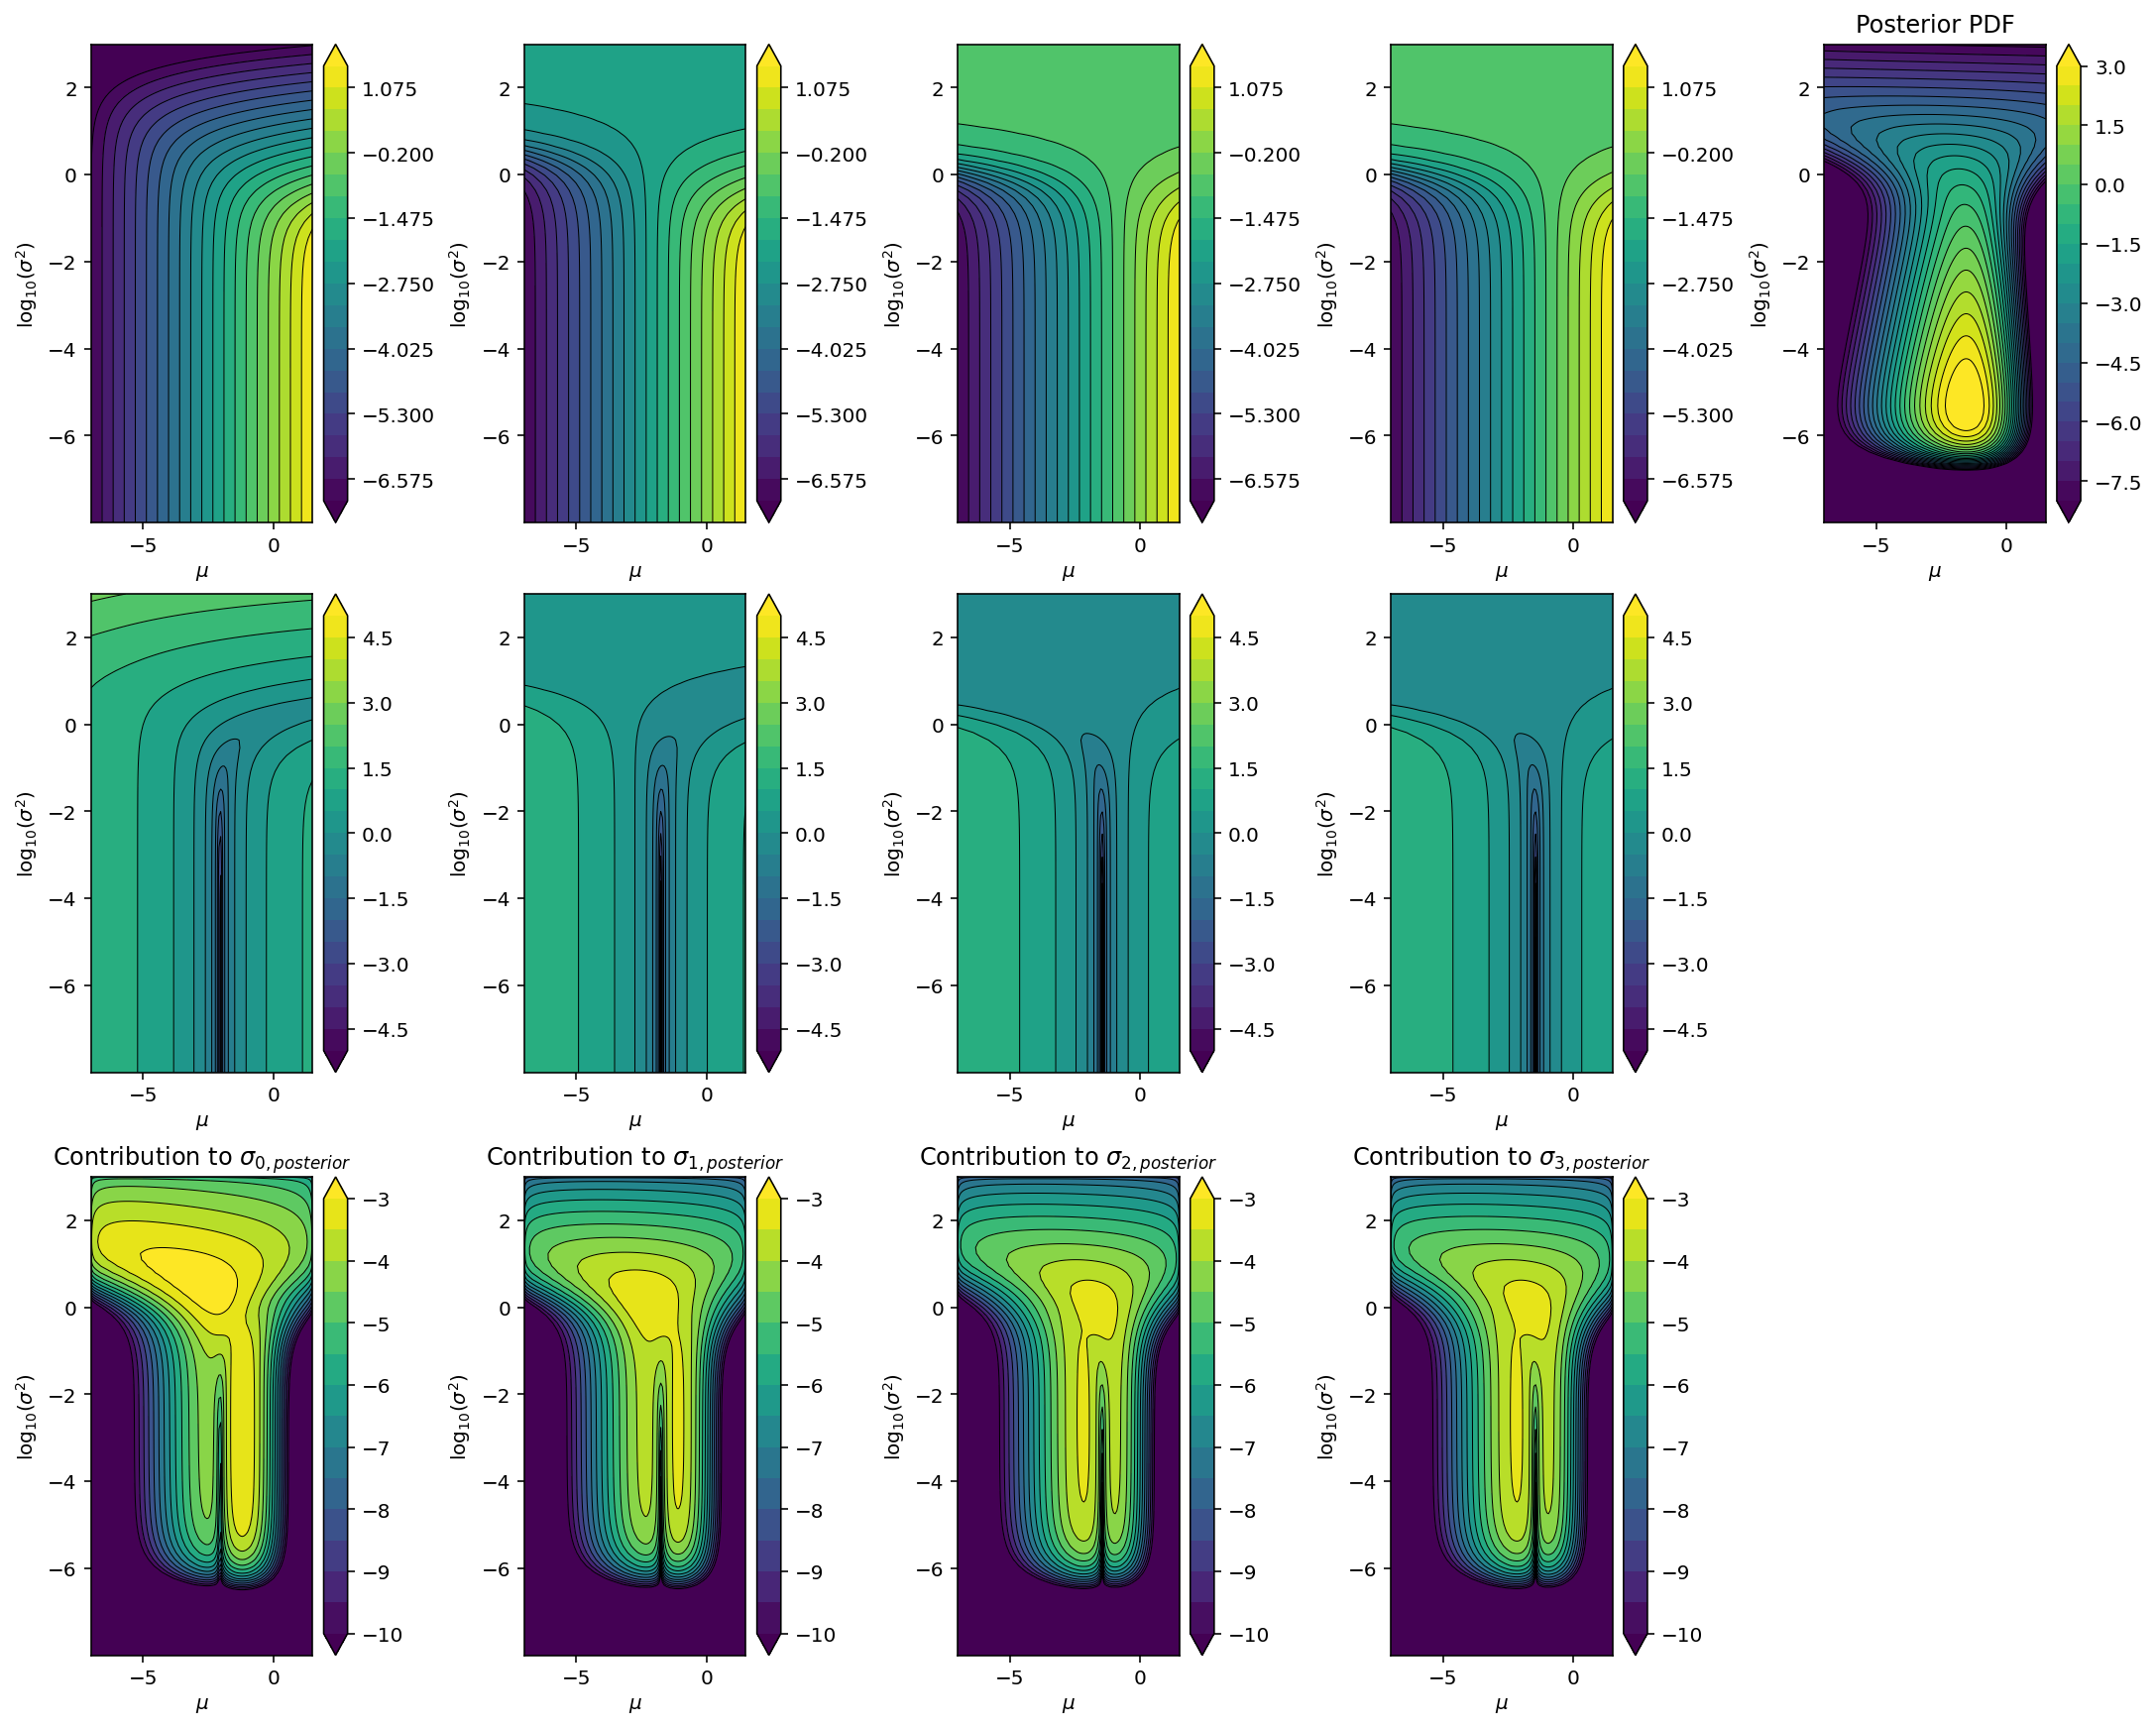

In [18]:
plt.figure(figsize=(15, 12), constrained_layout=True)
for i in range(4):
    F = T[0, :, :, i] * post_theta2[0, :, :]
    cell_volume = mu_rule[1][:, None] * sigma2_rule[1][None, :]
    cell_volume = scipy.ndimage.gaussian_filter(cell_volume, 1.0)
    plt.subplot(3, 5, 1 + i)
    plot_field(
        report2,
        x_mu[0, :, :, i],
        levels=np.linspace(mu_rule[0].min(), mu_rule[0].max(), 21),
    )
    plt.subplot(3, 5, 6 + i)
    plot_field(report2, np.log10(T[0, :, :, i]), levels=np.linspace(-5, 5, 21))
    plt.subplot(3, 5, 11 + i)
    plt.title("Contribution to $\sigma_{" + str(i) + ", posterior}$")
    plot_field(report2, np.log10(F * cell_volume), levels=np.linspace(-10, -3, 15))

plt.subplot(3, 5, 5)
plt.title("Posterior PDF")
plot_field(report2, np.log10(post_theta2[0, :]), levels=np.linspace(-8, 3, 23))
plt.show()

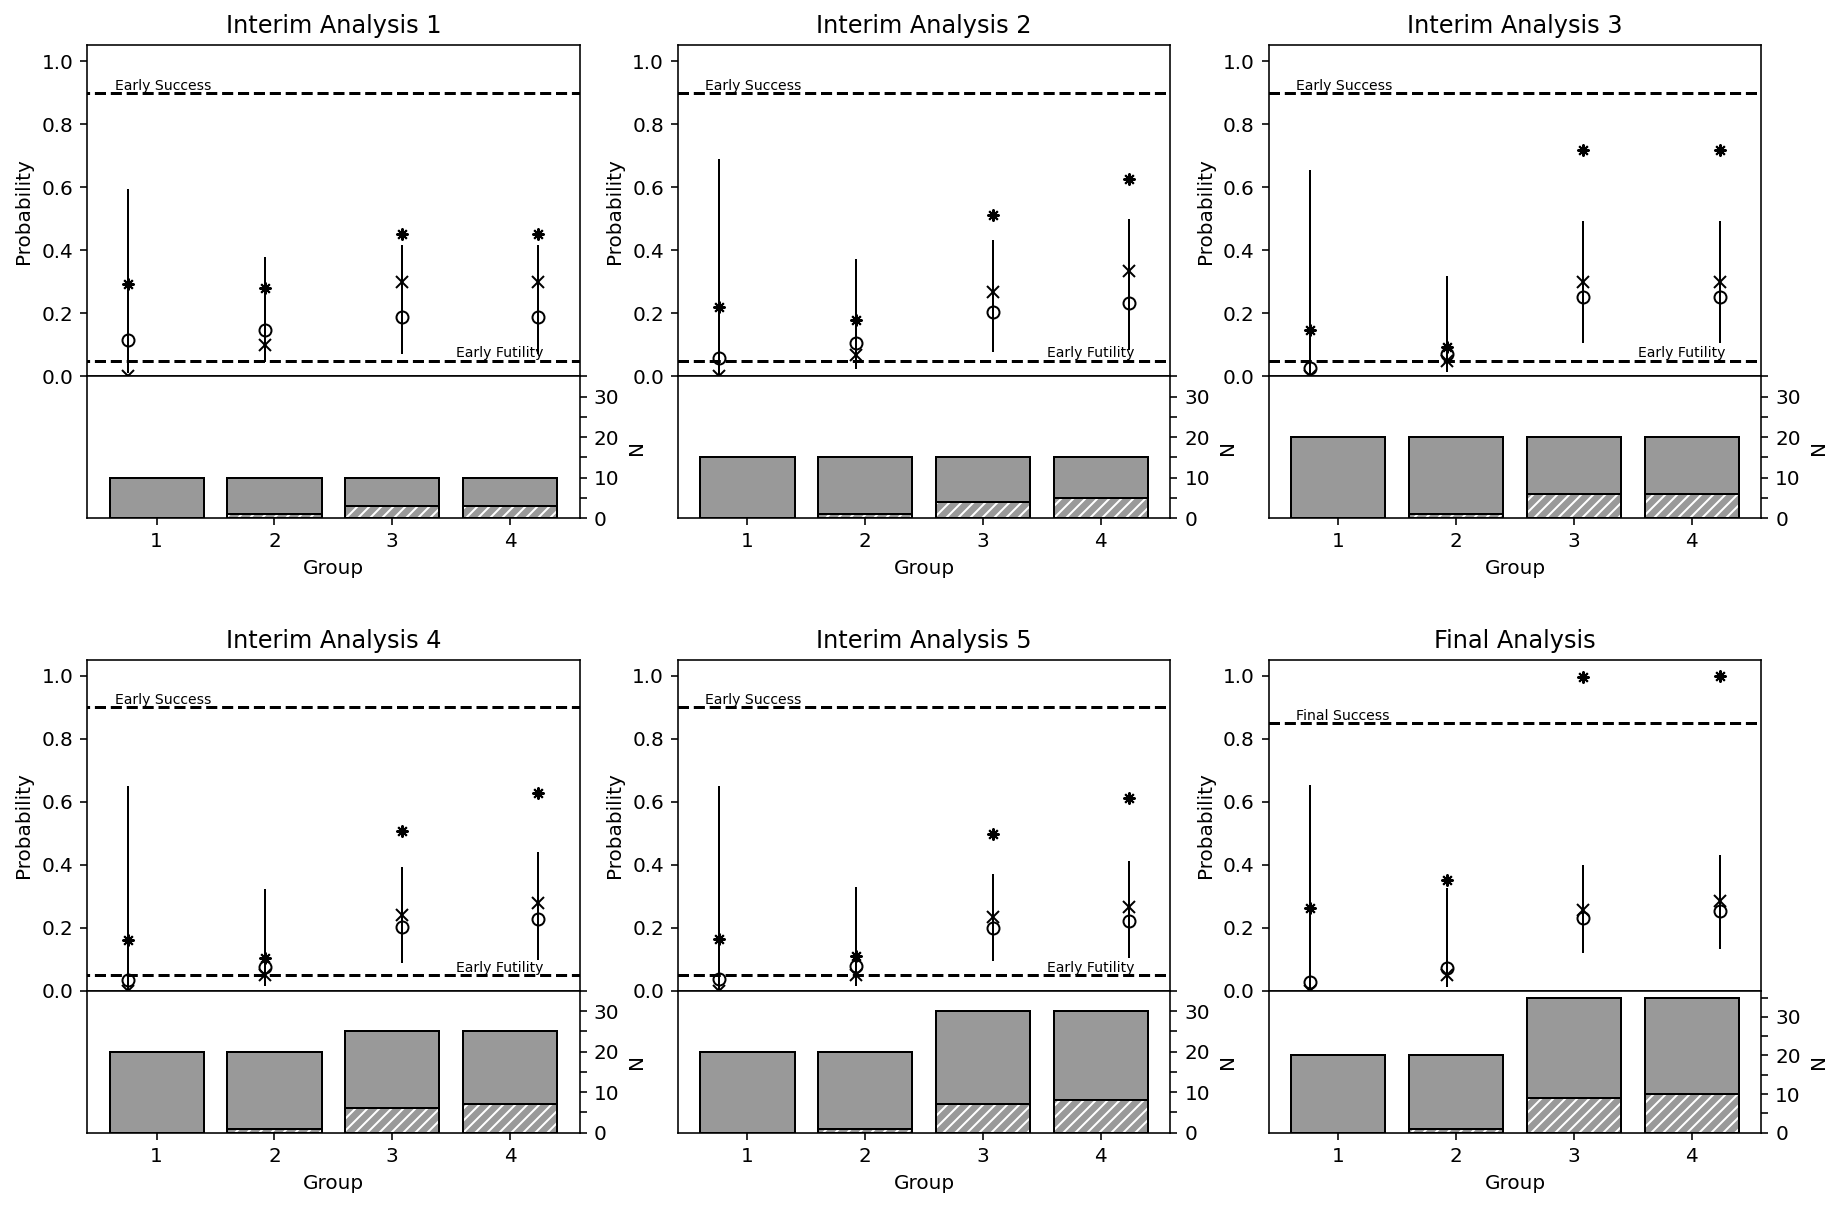

In [19]:
figure1_plot(data2, post_theta2, report2)

### Skewness in the marginals

Why is the confidence interval on the 0-th arm in the figure above so large? This is a case where one of the core INLA assumptions breaks down. INLA assumes that p(x|y,\theta) is approximately normal. In this particular case, that assumption is not correct. Intuitively, with 0 successes out of 20 patients, there is a lot more potential for small $x_0$ values than potential for large $x_0$ values. As you can see below, there is substantial skewness. There are approaches to deal with this. See here: https://github.com/mikesklar/kevlar/issues/15

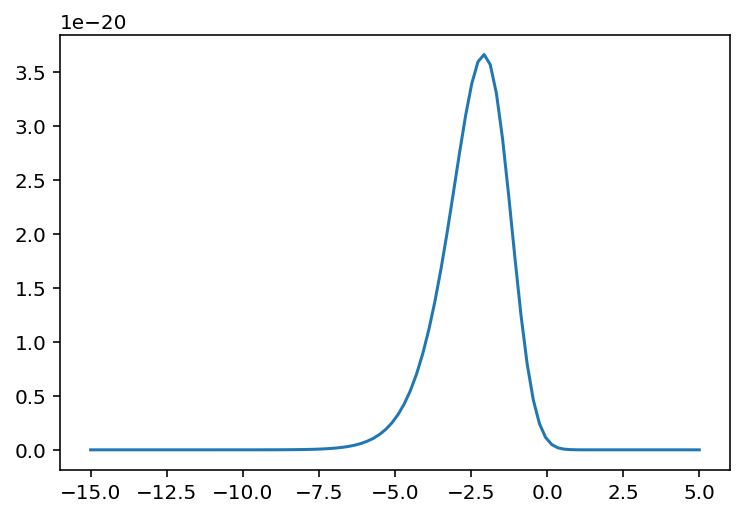

In [20]:
x0_vs = np.linspace(-15, 5, 100)
x123_vs = np.full_like(x0_vs, -1.0)
x = np.array([x0_vs, x123_vs, x123_vs, x123_vs]).T.copy()
lj = model.log_joint(model, x, data[0], np.array([[-1.0, 10.0]]))
plt.plot(x0_vs, np.exp(lj))
plt.show()

In [21]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta2, report2)

# expit(mu_post) is the posterior estimate of the mean probability.
p_post = scipy.special.expit(mu_post)

# two sigma confidence intervals transformed from logit to probability space.
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

In [22]:
cilow[0], cihigh[0]

(array([0.0111876 , 0.04650115, 0.07040077, 0.07040077]),
 array([0.59393357, 0.37904215, 0.41816045, 0.41816045]))

In [23]:
total_sum = np.sum(np.exp(lj))
mean = x0_vs[np.argmax(np.exp(lj))]
ci025 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.05)]
ci975 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.95)]
ci025, ci975, np.abs(mean-ci025), np.abs(mean-ci975), scipy.special.expit(ci025), scipy.special.expit(ci975)

(-4.292929292929292,
 -0.8585858585858581,
 2.2222222222222214,
 1.2121212121212128,
 0.013480627700845842,
 0.2976348849744225)

# Simulation

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np
import inla


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


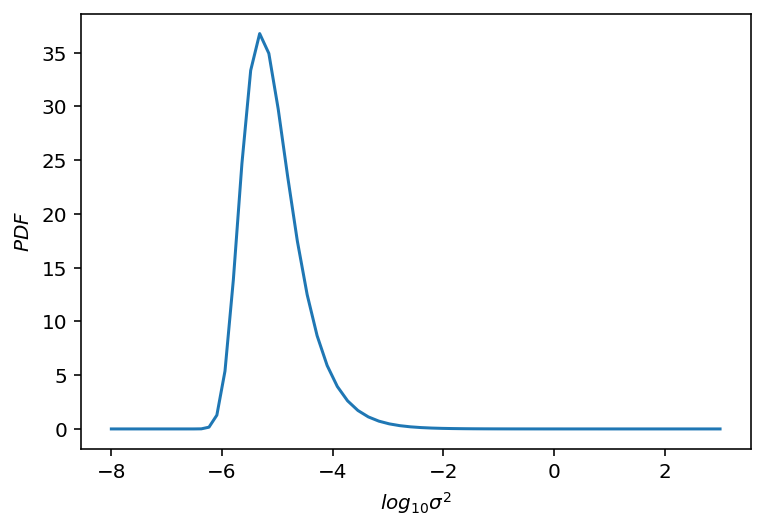

exact CDF:  0.00922569143991095
numerical integration CDF:  0.009225691439910979
error:  2.7755575615628914e-17


In [25]:

def log_gauss_rule(N, a, b):
    A = np.log(a)
    B = np.log(b)
    p, w = inla.gauss_rule(N, a=A, b=B)
    pexp = np.exp(p)
    wexp = np.exp(p) * w
    return (pexp, wexp)

a = 1e-8
b = 1e3
pexp, wexp = log_gauss_rule(90, a, b)
alpha = 0.0005
beta = 0.000005
f = scipy.stats.invgamma.pdf(pexp, alpha, scale=beta)
exact = scipy.stats.invgamma.cdf(b, alpha, scale=beta) - scipy.stats.invgamma.cdf(a, alpha, scale=beta)
est = np.sum(f * wexp)
plt.plot(np.log(pexp) / np.log(10), f)
plt.xlabel('$log_{10}\sigma^2$')
plt.ylabel('$PDF$')
plt.show()
print('exact CDF: ', exact),
print('numerical integration CDF: ', est)
print('error: ', est - exact)
sigma2_rule = (pexp, wexp)

In [26]:
p0 = np.array([0.05, 0.05, 0.1, 0.2]) # rate of response below this is the null hypothesis
p1 = np.array([0.2, 0.2, 0.3, 0.4]) # rate of response above this is the alternative hypothesis.
# p0 = np.array([0.1, 0.1, 0.1, 0.1]) # rate of response below this is the null hypothesis
# p1 = np.array([0.3, 0.3, 0.3, 0.3]) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_x = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_x = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.array([0.82, 0.82, 0.85, 0.9])

# early stopping criteria
pmid_accept = 0.9
pmid_fail = 0.05

prior_mu_mean = scipy.special.logit(0.1)

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

In [27]:
%load_ext line_profiler

In [28]:
np.random.seed(1000)

def sim(n_sims, N, p):
    return np.stack(
        (scipy.stats.binom.rvs(N, p, size=(n_sims, 4)), np.full((n_sims, 4), N)), axis=2
    )

n_sims = 200

scenarios = {
    "Null": [0.05, 0.05, 0.1, 0.2],
    "Alternative": [0.2, 0.2, 0.3, 0.4],
    "One in the Middle": [0.2, 0.2, 0.2, 0.5],
    "All in the Middle": [0.15, 0.15, 0.2, 0.3],
    "One Nugget": [0.05, 0.05, 0.1, 0.4],
    "2 Null, 2 Alternative": [0.05, 0.05, 0.3, 0.4],
}

# Number of patients at the first look.
N_0 = 10

# Number of patients added per look.
deltaN = 5


In [29]:
results = dict()
n_looks = 6
for k in scenarios:
    results[k] = dict(
        data=[], mu_post=[], sigma_post=[], p_success=[], success_by_look=[]
    )
    p = scenarios[k]
    data = sim(n_sims, N_0, p)

    results[k]["data"] = []
    success = np.zeros((n_sims, 4), dtype=bool)
    stopping_time = np.full((n_sims, 4), -1, dtype=np.int32)
    for look in range(n_looks):
        results[k]["data"].append(data.copy())

        mu_rule = inla.gauss_rule(21, -5, 5)
        sigma2_rule = log_gauss_rule(21, 1e-7, 1e3)
        post_theta, report = inla.calc_posterior_theta(
            model, data, (mu_rule, sigma2_rule)
        )
        mu_post, sigma_post = inla.calc_posterior_x(post_theta, report)
        results[k]["mu_post"].append(mu_post)
        results[k]["sigma_post"].append(sigma_post)

        if look < 5:
            p_success = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post, sigma_post)
            stop_success = 0 * (p_success > pmid_accept) # no early stopping for success
            stop_fail = p_success < pmid_fail
        else:
            p_success = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post, sigma_post)
            stop_success = p_success > pfinal_thresh[None, :]
            stop_fail = p_success <= pfinal_thresh[None, :]
        success[stop_success] = True
        stop = stop_success | stop_fail
        update_stopping = (stop & (stopping_time == -1)).astype(bool)
        stopping_time[update_stopping] = look

        results[k]["p_success"].append(p_success)
        results[k]["success_by_look"].append(stop_success)

        new_data = sim(n_sims, deltaN, p)
        data += new_data
    results[k]["success_by_look"] = np.array(results[k]["success_by_look"])
    results[k]['stopping_time'] = stopping_time
    results[k]['success'] = success

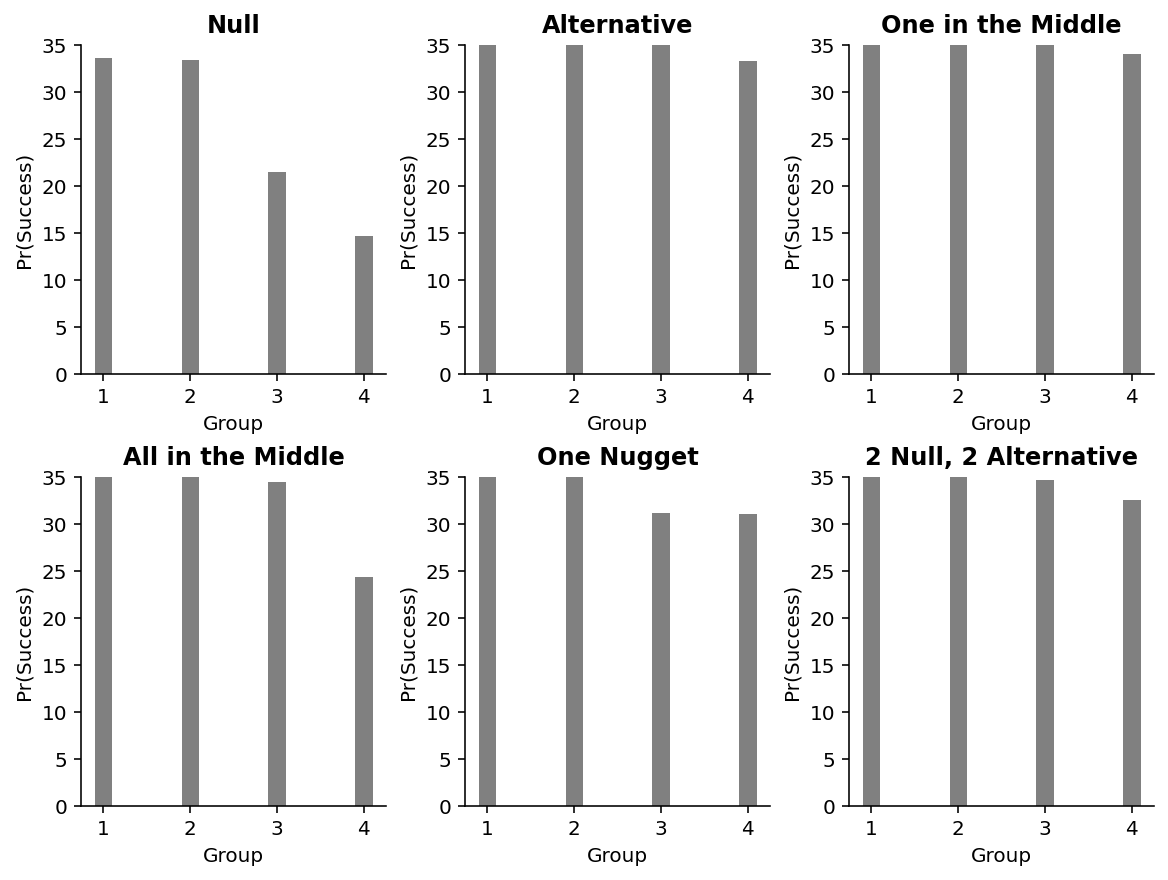

In [30]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(scenarios):
    sample_size = N_0 + results[k]['stopping_time'] * deltaN
    mean_sample_size = np.mean(sample_size, axis=0)

    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight='bold')
    plt.bar(np.arange(4), mean_sample_size, 0.2, color='gray', )

    plt.ylim([0, 35])
    plt.yticks(np.arange(0, 36, 5))
    plt.ylabel('Pr(Success)')

    plt.xticks(np.arange(4), ['1', '2', '3', '4'])
    plt.xlabel('Group')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
plt.show()

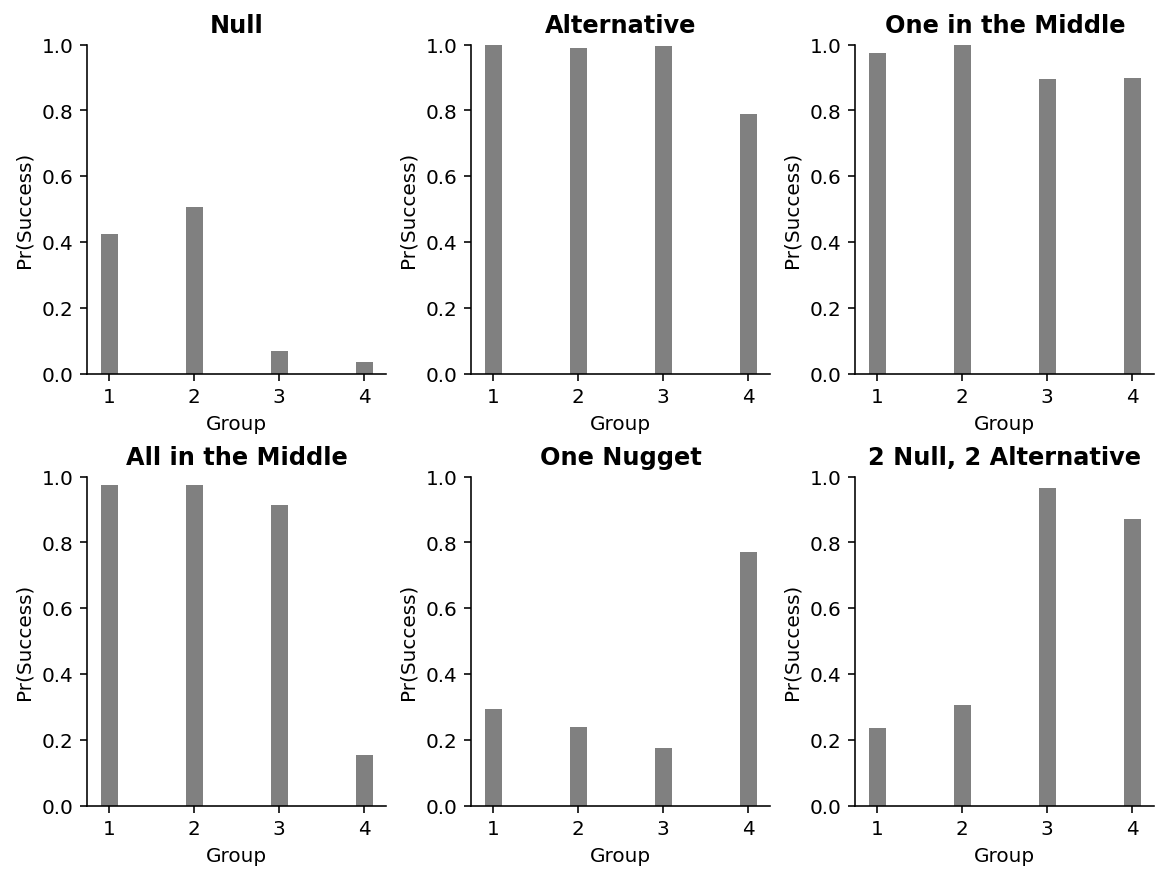

In [31]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(results):
    success = results[k]['success']
    n_sims = success.shape[0]
    success_rate = success.sum(axis=0) / n_sims
    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight='bold')
    plt.bar(np.arange(4), success_rate, 0.2, color='gray', )

    plt.ylim([0, 1])
    plt.yticks(np.linspace(0, 1, 6))
    plt.ylabel('Pr(Success)')

    plt.xticks(np.arange(4), ['1', '2', '3', '4'])
    plt.xlabel('Group')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)